In [1]:
#DATOS
import random
import numpy as np
import pandas as pd

# Coordenadas de los puntos de recogida y la escuela
puntos_recogida = {
    'Punto': ['P{}'.format(i) for i in range(1, 90)] + ['Escuela'],
    'Coordenada_X': [random.randint(1, 40) for _ in range(90)],
    'Coordenada_Y': [random.randint(1, 40) for _ in range(90)],
    'Estudiantes': [random.randint(5, 30) if i < 89 else 0 for i in range(90)]  # Último valor para la escuela es 0
}
df_puntos = pd.DataFrame(puntos_recogida)

# Distancias entre los puntos (en km)
# Para simplificar, generamos una matriz de distancias basada en la distancia euclidiana
paradas = df_puntos[['Coordenada_X', 'Coordenada_Y']].values

velocidad_media=40

# Imprimimos los datos
print("Puntos de recogida y escuela:\n", df_puntos)

Puntos de recogida y escuela:
       Punto  Coordenada_X  Coordenada_Y  Estudiantes
0        P1            18            25           25
1        P2             6            28           23
2        P3            10            40           11
3        P4            10             6           28
4        P5            21            14           18
..      ...           ...           ...          ...
85      P86            37             5           16
86      P87            19            22           13
87      P88            26             3            6
88      P89            37            26           20
89  Escuela            23            10            0

[90 rows x 4 columns]


In [2]:
import numpy as np
from pymoo.core.repair import Repair

class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.core.problem import ElementwiseProblem


class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):

        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)

        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=2,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia, tiempo]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        Max_dist=self.get_route_length(x)-250
        
        Max_tiempo=self.get_route_length(x)/velocidad_media-250

        x_ord=np.sort(x)
        penalty_paradas=0
        for i in range(len(x_ord)-1):
            if x_ord[i] == x_ord[i+1]:
                penalty_paradas=10000
                
        out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist


def visualize_3(problem, x, n, fig=None, ax=None, show=True, label=True):
 with plt.style.context('ggplot'):
        x=x[0]
        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # plot cities using scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # annotate cities
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # plot the line on the path
        for i in range(len(x)-1):
            current = x[i]
            next_ = x[(i + 1)]
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        fig.suptitle(f"Route length: {problem.get_route_length(x)}km \nRoute time: {problem.get_route_length(x)*60/velocidad_media}min")

        if show:

            X, F = res.opt.get("X", "F")
    
        from pymoo.visualization.scatter import Scatter
        
        plot = Scatter()
        plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
        plot.add(res.F, facecolor="none", edgecolor="red")
        %matplotlib inline

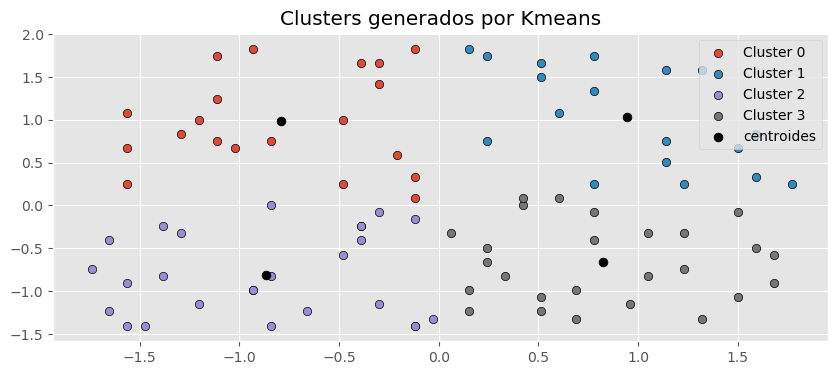

In [17]:
n_barcos = 4

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

In [18]:
y_predict

array([0, 0, 0, 2, 3, 2, 2, 1, 1, 1, 3, 2, 2, 0, 2, 3, 1, 3, 3, 3, 0, 3,
       1, 2, 2, 3, 2, 3, 0, 2, 0, 1, 0, 3, 1, 0, 3, 2, 3, 2, 0, 3, 2, 3,
       3, 2, 2, 1, 1, 2, 1, 3, 2, 3, 2, 2, 0, 0, 0, 2, 3, 3, 1, 1, 2, 0,
       1, 0, 1, 2, 0, 1, 3, 0, 2, 2, 0, 1, 2, 3, 2, 3, 3, 1, 0, 3, 0, 3,
       1, 3], dtype=int32)

In [19]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation
import matplotlib
from pymoo.config import Config
Config.warnings['not_compiled'] = False

matplotlib.use('TkAgg')

#Creamos un diccionario para almacenar cada ruta
rutas={}
stops=paradas
fitness=[]
for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:,0].T, stops[:,1].T, y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):

    stops=rutas[f"ruta_{i}"]
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)

    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        repair=StartFromZeroRepair(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )
    
    # if the algorithm did not improve the last 200 generations then it will terminate (and disable the max generations)
    #termination = DefaultSingleObjectiveTermination(period=200, n_max_gen=np.inf)
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    print("Maximum Span:", np.round(res.F[0], 3))
    print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos)
    


0
1
2
3
Maximum Span: [83.026  2.076]
Function Evaluations: 2000
[[ 0  6 15 19  9 17 10  1  3 18  4  7 14  8  2 11 12 16 13  5]]
Maximum Span: [69.872  1.747]
Function Evaluations: 2000
[[ 0 12  7 14 15 16  9  3 11  4  1 10 13  6  8  2 17  5]]
Maximum Span: [92.531  2.313]
Function Evaluations: 2000
[[ 0  1 19 20 16  5  2  7  8  4 13 14 12 21 11 18 23 10  3 17 24  6 22  9
  25 15]]
Maximum Span: [96.013  2.4  ]
Function Evaluations: 2000
[[ 0 22 25 21 24 19 18  8 13 15 17  9  5  6 12 14  3  1  7 20 11 10  2 23
   4 16]]


In [7]:
hist = res.history
print(len(hist))

n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

100


NameError: name 'F' is not defined

In [ ]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

In [ ]:
last_three_gen = hist_F[-3:]  # Últimas 3 generaciones
gen_1 = hist_F[5]
gen_75 = hist_F[75]
gen_100 = hist_F[99]

In [ ]:
# Crear la figura para plotear
plt.figure(figsize=(10, 6))

plt.scatter(gen_1[:, 0], gen_1[:, 1], label='Generación 1', s=30)
plt.scatter(gen_75[:, 0], gen_75[:, 1], label='Generación 75', s=30)
plt.scatter(gen_100[:, 0], gen_100[:, 1], label='Generación 100', s=30)

# Etiquetas y título del gráfico
plt.title('Fitness de las Últimas 3 Generaciones en el Espacio Objetivo')
plt.xlabel('Objetivo 1')
plt.ylabel('Objetivo 2')
plt.legend()
plt.show()

In [ ]:
from pymoo.core.population import Population
import pandas as pd

# Inicializar una población vacía para acumular los valores de fitness
all_fitness = Population()

# Recorrer el historial de generaciones
for algorithm in res.history:
    # En cada iteración, fusionamos los valores de fitness de la generación actual
    all_fitness = Population.merge(all_fitness, algorithm.pop)  # 'algorithm.pop' contiene la población de la generación

# Obtener los valores de fitness de todas las generaciones
fitness_values = all_fitness.get("F")  # "F" representa los valores de las funciones objetivo (fitness)

# Convertir los valores de fitness en un DataFrame de pandas
df_fitness = pd.DataFrame(fitness_values, columns=[f"F{i+1}" for i in range(problem.n_obj)])

# Mostrar el DataFrame con los valores de fitness
print(df_fitness)


In [ ]:
from pymoo.core.population import Population
import pandas as pd
    
# Inicializar una población vacía y una lista para almacenar las generaciones
all_fitness = Population()
generations = []

# Recorrer el historial de generaciones
for gen_idx, algorithm in enumerate(res.history):
    # Fusionar las soluciones (poblaciones) de cada generación
    all_fitness = Population.merge(all_fitness, algorithm.pop)
    
    # Para cada solución en la población de esta generación, agregar el número de generación
    generations += [gen_idx] * len(algorithm.pop)  # Añade el índice de la generación tantas veces como soluciones tenga la población

# Obtener los valores de fitness de todas las generaciones
fitness_values = all_fitness.get("F")  # "F" representa los valores de las funciones objetivo

# Crear un DataFrame con los valores de fitness
df_fitness = pd.DataFrame(fitness_values, columns=[f"F{i+1}" for i in range(problem.n_obj)])

# Añadir una columna extra con el número de generación
df_fitness["Generación"] = generations

# Mostrar el DataFrame con los valores de fitness y el número de generación
print(df_fitness)


In [ ]:
from pymoo.visualization.scatter import Scatter
plt.figure()    
plot = Scatter()
plot.add(problem.pareto_front(), color="black", alpha=0.7)
plot.add(res.F)

%matplotlib inline

plot.show()

In [ ]:
# Filtrar el DataFrame para obtener solo las soluciones de la generación 99
df_gen_99 = df_fitness[df_fitness["Generación"] == 99]
df_gen_80 = df_fitness[df_fitness["Generación"] == 80]

# Asumamos que tienes dos funciones objetivo (F1 y F2)
# Cambia esto si tienes más de dos funciones objetivo
f1_values = df_gen_99["F1"].values
f2_values = df_gen_99["F2"].values
f1_values_80 = df_gen_80["F1"].values
f2_values_80 = df_gen_80["F2"].values

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.scatter(f1_values, f2_values, label='Última generación')
plt.scatter(f1_values_80, f2_values_80, color='green', label='Primera generación')

# Configurar etiquetas y título
plt.xlabel('F1')
plt.ylabel('F2')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [8]:
len(df_gen_99)

NameError: name 'df_gen_99' is not defined